# Topological regularization of cell cycle embedding

In this notebook, we show how a topological loss can be combined with a linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Loading R objects into python
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Pytorch compatible topology layer and losses
import torch
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss, pca_loss, ortho_loss

# Random sampling for topological loss
import random

# Ordinary and topologically regularized PCA embedding
from Code.topembed import PCA

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Quantitative evaluation
from sklearn.svm import SVC
from Code.evaluation import evaluate_embeddings

%matplotlib inline

## Load data and view ordinary PCA embedding

We start by loading the data and visualize it by means of its ordinary PCA embedding.

Data shape: (264, 6812)
Time for embedding: 00:00:00


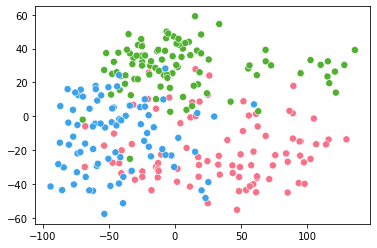

In [2]:
# Load the data
file_name = os.path.join("Data", "CellCycle.rds")
cell_info = ro.r["readRDS"](file_name)
cell_info = dict(zip(cell_info.names, list(cell_info)))

pandas2ri.activate()
data = ro.conversion.rpy2py(cell_info["expression"])
t = list(ro.conversion.rpy2py(cell_info["cell_info"])
         .rename(columns={"milestone_id": "group_id"}).loc[:,"group_id"])
pandas2ri.deactivate()

print("Data shape: " + str(data.shape))

# Conduct ordinary PCA embedding
Y_pca, W_pca = PCA(data, random_state=42)

# View the data through its PCA embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_pca[:,0], y=Y_pca[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

## Apply topological regularization to the embedding

We now show how we can bias a linear embedding using a loss function that captures our topological prior.

The model we will use for this learns a linear projection $W$, which is optimized for the following three losses:
- the reconstruction loss between our data and its $X$ low-rank approximation $XWW^T$;
- a loss function encouraging orthonormality of $W$;
- a loss function that captures our topological prior.

As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [3]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
CircularPersistence = DiagramLoss(dim=1, j=1, g=g) # compute persistence of most prominent cycle
lambda_top = -1e2 # scalar factor that trades off embedding and topological loss
top_frac = 0.25 # sample fraction for which the topological loss is computed

# Construct topological loss function
def top_loss(output):
    if top_frac < 1:
        sample = random.sample(range(output.shape[0]), int(output.shape[0] * top_frac))
        output = output[sample,:]  
    dgminfo = TopLayer(output)
    loss = lambda_top * CircularPersistence(dgminfo)
    
    return loss

We can now conduct the topologically regularized linear embedding as follows.

[epoch 1] [emb. loss: 6.704727, ortho. loss: 0.001194, top. loss: -1029.116089, total loss: -1022.410156]
[epoch 100] [emb. loss: 6.794199, ortho. loss: 39.050903, top. loss: -2206.719482, total loss: -2160.874268]
[epoch 200] [emb. loss: 6.871301, ortho. loss: 28.582264, top. loss: -3853.351318, total loss: -3817.897705]
[epoch 300] [emb. loss: 6.911356, ortho. loss: 15.225312, top. loss: -4771.732422, total loss: -4749.595703]
[epoch 400] [emb. loss: 6.944156, ortho. loss: 78.957901, top. loss: -5473.927246, total loss: -5388.025391]
[epoch 500] [emb. loss: 6.963151, ortho. loss: 68.097542, top. loss: -3985.763672, total loss: -3910.702881]
[epoch 600] [emb. loss: 6.969546, ortho. loss: 54.162918, top. loss: -5400.137207, total loss: -5339.004883]
[epoch 700] [emb. loss: 6.980327, ortho. loss: 28.453640, top. loss: -5472.357422, total loss: -5436.923340]
[epoch 800] [emb. loss: 6.993236, ortho. loss: 55.716778, top. loss: -5505.524414, total loss: -5442.814453]
[epoch 900] [emb. loss

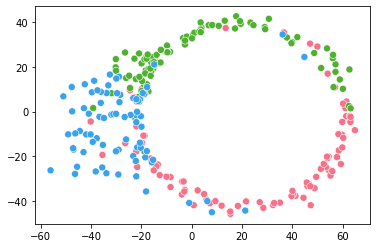

In [4]:
# Learning hyperparameters
num_epochs = 1000
learning_rate = 5e-4

# Conduct topological regularization
Y_top, W_top, losses_top = PCA(data, top_loss=top_loss, num_epochs=num_epochs, 
                               learning_rate=learning_rate, random_state=42)

# View topologically regularized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_top[:,0], y=Y_top[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

We observe that we can regularize our linear embedding through the topological prior, obtaining a much more prominent cycle, while maintaining a nearly identical reconstruction error.

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the initialized embedding.

[epoch 1] [emb. loss: 0.000000, ortho. loss: 0.001194, top. loss: -1029.116089, total loss: -1029.114868]
[epoch 100] [emb. loss: 0.000000, ortho. loss: 60.290764, top. loss: -2210.136719, total loss: -2149.845947]
[epoch 200] [emb. loss: 0.000000, ortho. loss: 34.799610, top. loss: -2403.161133, total loss: -2368.361572]
[epoch 300] [emb. loss: 0.000000, ortho. loss: 43.243652, top. loss: -5054.873047, total loss: -5011.629395]
[epoch 400] [emb. loss: 0.000000, ortho. loss: 49.574078, top. loss: -5114.975098, total loss: -5065.400879]
[epoch 500] [emb. loss: 0.000000, ortho. loss: 46.421947, top. loss: -3617.493896, total loss: -3571.072021]
[epoch 600] [emb. loss: 0.000000, ortho. loss: 101.706757, top. loss: -5488.114746, total loss: -5386.408203]
[epoch 700] [emb. loss: 0.000000, ortho. loss: 33.808533, top. loss: -5564.112793, total loss: -5530.304199]
[epoch 800] [emb. loss: 0.000000, ortho. loss: 51.712521, top. loss: -5432.167969, total loss: -5380.455566]
[epoch 900] [emb. los

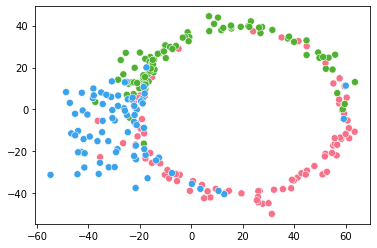

In [5]:
# Learning hyperparameters
num_epochs = 1000
learning_rate = 5e-4

# Conduct topological optimization
Y_opt, W_opt, losses_opt = PCA(data, emb_loss=False, top_loss=top_loss, num_epochs=num_epochs, 
                               learning_rate=learning_rate, random_state=42)

# View topologically optimized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_opt[:,0], y=Y_opt[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

We observe that the results are highly similar.

## Quantitative evaluation

First, we evaluate the different losses (embedding and topological) for all final embeddings.

In [6]:
n_samples = 250 # number of samples for approximating (expected value of) topological loss
random.seed(42)

print("\033[1mLosses for pca embedding: \033[0m")
print("Reconstruction: " + str(losses_top["embedding"][0])) # PCA initialization gives first embedding loss
print("Orthonormality: " + str(ortho_loss(torch.tensor(W_pca)).item()))
print("Topological: " + str(np.mean([top_loss(torch.tensor(Y_pca).type(torch.float)) for _ in range(n_samples)]) 
                            / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically optimized pca embedding: \033[0m")
print("Reconstruction: " + str(pca_loss(torch.tensor(data - data.mean(axis=0)), 
                                        torch.tensor(W_opt), torch.tensor(Y_opt)).item()))
print("Orthonormality: " + str(ortho_loss(torch.tensor(W_opt)).item()))
print("Topological: " + str(np.mean([top_loss(torch.tensor(Y_opt).type(torch.float)) for _ in range(n_samples)]) 
                            / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically regularized pca embedding: \033[0m")
print("Reconstruction: " + str(pca_loss(torch.tensor(data - data.mean(axis=0)), 
                                        torch.tensor(W_top), torch.tensor(Y_top)).item()))
print("Orthonormality: " + str(ortho_loss(torch.tensor(W_top)).item()))
print("Topological: " + str(np.mean([top_loss(torch.tensor(Y_top).type(torch.float)) for _ in range(n_samples)]) 
                            / np.abs(lambda_top)))

Losses for pca embedding: 
Reconstruction: 6.7047271728515625
Orthonormality: 1.831467351571864e-15
Topological: -13.417724609375

Losses for topologically optimized pca embedding: 
Reconstruction: 7.001532540225682
Orthonormality: 0.004188908729702234
Topological: -50.91328125

Losses for topologically regularized pca embedding: 
Reconstruction: 6.990493646422851
Orthonormality: 0.004286207724362612
Topological: -49.7297021484375


Finally, we compare if the topologically regularized embedding improves on the ordinary PCA embedding for predicting data point labels.

In [7]:
# Machine learning model to be used for label prediction
Ys = {"pca": Y_pca, "top. opt.": Y_opt, "top. reg.": Y_top}
model = SVC()
scoring = "accuracy"

# Hyperparameters for quantitative evaluation
ntimes = 100
test_frac = 0.1
params = {"C":[0.01, 0.1, 1, 10, 100]}

# Obtain performances over multiple train-test splits
performances = evaluate_embeddings(Ys, t, model, scoring, params=params, stratify=t, 
                                   ntimes=ntimes, test_frac=test_frac, random_state=42)

# View resulting performances
pd.concat([pd.DataFrame({"mean":performances.mean(axis=0)}),
           pd.DataFrame({"std":performances.std(axis=0)})], axis=1)\
            .style.highlight_max(subset="mean", color="lightgreen", axis=0)

,mean,std
pca,0.787778,0.070402
top. opt.,0.792963,0.072771
top. reg.,0.807037,0.071076
